## IMPORT

In [115]:
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display_html
import numpy as np
import datetime as dt

## PATH

In [116]:
ROOT = Path.cwd().parent

data_path = ROOT / 'data'

## LOAD DATA

In [117]:
df_norm = pd.read_csv(data_path / 'dati_leo_normalizzati.csv').drop(columns=['total'])
df = pd.read_csv(data_path / 'dati_leo_assoluti.csv')

## LOTKA VOLTERRA BASICO

In [118]:
df = df_norm

In [119]:
df = df.drop(columns = ['Europe'])

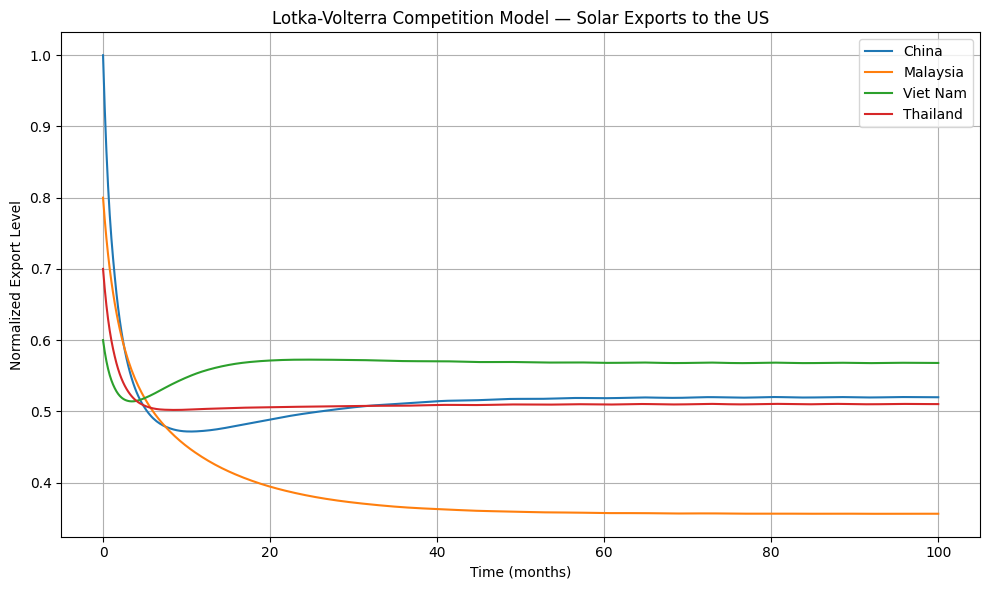

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def lotka_volterra_4_explicit(t, X, r1, r2, r3, r4,
                               a11, a12, a13, a14,
                               a21, a22, a23, a24,
                               a31, a32, a33, a34,
                               a41, a42, a43, a44):
    x1, x2, x3, x4 = X

    dx1dt = r1 * x1 * (1 - a11 * x1 - a12 * x2 - a13 * x3 - a14 * x4)
    dx2dt = r2 * x2 * (1 - a21 * x1 - a22 * x2 - a23 * x3 - a24 * x4)
    dx3dt = r3 * x3 * (1 - a31 * x1 - a32 * x2 - a33 * x3 - a34 * x4)
    dx4dt = r4 * x4 * (1 - a41 * x1 - a42 * x2 - a43 * x3 - a44 * x4)

    return [dx1dt, dx2dt, dx3dt, dx4dt]

# Parameters
params = {
    'r1': 0.5, 'r2': 0.3, 'r3': 0.4, 'r4': 0.45,
    'a11': 1.0, 'a12': 0.6, 'a13': 0.2, 'a14': 0.3,
    'a21': 0.3, 'a22': 1.0, 'a23': 0.5, 'a24': 0.4,
    'a31': 0.4, 'a32': 0.2, 'a33': 1.0, 'a34': 0.3,
    'a41': 0.3, 'a42': 0.3, 'a43': 0.4, 'a44': 1.0
}

# Initial conditions
X0 = [1.0, 0.8, 0.6, 0.7]  # China, Malaysia, Viet Nam, new exporter (e.g., Thailand)

# Time span and evaluation points
t_span = (0, 100)
t_eval = np.linspace(*t_span, 500)

# Solve the system
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_4_explicit(t, X, **params),
    t_span=t_span,
    y0=X0,
    t_eval=t_eval,
    method='RK45'
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='China')
plt.plot(sol.t, sol.y[1], label='Malaysia')
plt.plot(sol.t, sol.y[2], label='Viet Nam')
plt.plot(sol.t, sol.y[3], label='Thailand')  # Replace with desired country
plt.title('Lotka-Volterra Competition Model — Solar Exports to the US')
plt.xlabel('Time (months)')
plt.ylabel('Normalized Export Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [121]:
df

,Time,China,JP+KR,SoutheastAsia,Taiwan
0,2002-01-01,0.110311,0.380993,0.352239,0.054684
1,2002-02-01,0.093534,0.454315,0.287546,0.057884
2,2002-03-01,0.107718,0.406185,0.349512,0.052608
3,2002-04-01,0.123506,0.467669,0.310324,0.044436
4,2002-05-01,0.110933,0.290828,0.515878,0.033958
...,...,...,...,...,...
235,2021-08-01,0.062298,0.204443,0.632360,0.041596
236,2021-09-01,0.055998,0.177974,0.663774,0.046366
237,2021-10-01,0.038418,0.136539,0.749306,0.035138
238,2021-11-01,0.054520,0.176605,0.676466,0.040333


## CALIBRATION

In [122]:
from scipy.optimize import least_squares

china_data = df['China']
taiwan_data = df['Taiwan']
jp_kr_data = df['JP+KR']
se_data = df['SoutheastAsia']

# Stack data for comparison
data = np.vstack([china_data, taiwan_data, jp_kr_data, se_data])  # shape (3, T)
t_data = np.linspace(0, len(china_data)-1, len(china_data))  # e.g. months

In [123]:
def residuals(params, X0, t_data, data):
    # Unpack parameters
    r1, r2, r3, r4 = params[:4]
    a11, a12, a13, a14 = params[4:8]
    a21, a22, a23, a24 = params[8:12]
    a31, a32, a33, a34 = params[12:16]
    a41, a42, a43, a44 = params[16:]

    # Solve the system
    sol = solve_ivp(
        fun=lambda t, X: lotka_volterra_4_explicit(t, X,
                                                   r1, r2, r3, r4,
                                                   a11, a12, a13, a14,
                                                   a21, a22, a23, a24,
                                                   a31, a32, a33, a34,
                                                   a41, a42, a43, a44),
        t_span=(t_data[0], t_data[-1]),
        y0=X0,
        t_eval=t_data,
        method='RK45'
    )

    # Check for integration failure
    if sol.y.shape[1] != len(t_data):
        return np.ones(data.size) * 1e6

    # Return flattened residuals
    return (sol.y - data).ravel()


In [132]:
from scipy.optimize import least_squares

# Initial guess for 4 species: r1–r4, a11–a44 (row-wise)
initial_guess = [
    0.5, 0.3, 0.4, 0.35,        # r1, r2, r3, r4
    1.0, 0.6, 0.2, 0.1,         # a11, a12, a13, a14
    0.3, 1.0, 0.5, 0.2,         # a21, a22, a23, a24
    0.4, 0.2, 1.0, 0.3,         # a31, a32, a33, a34
    0.2, 0.4, 0.3, 1.0          # a41, a42, a43, a44
]

# Initial export levels from your data (must be shape (4,))
X0 = data[:, 0]

# Bounds (e.g., positive parameters only, up to 10)
lower_bounds = [0] * 20
upper_bounds = [2] * 20

# Fit the model to data
result = least_squares(
    residuals,
    initial_guess,
    args=(X0, t_data, data),
    bounds=(lower_bounds, upper_bounds)
)

# Extract fitted parameters
fitted_params = result.x


In [125]:
# from scipy.integrate import solve_ivp
# import numpy as np

# def simulate_lv(X0, t_span, t_eval, params):
#     sol = solve_ivp(
#         fun=lotka_volterra_4_explicit,
#         t_span=t_span,
#         y0=X0,
#         t_eval=t_eval,
#         args=tuple(params),  # flat list of 20 params
#         method='RK45',
#         vectorized=False
#     )
    
#     if not sol.success:
#         raise RuntimeError("ODE solver failed: " + sol.message)
    
#     return sol.y  # shape: (4, len(t_eval))

# def residuals(params, X0, t_data, data, sigma=0.1):
#     try:
#         X_sim = simulate_lv(X0, (t_data[0], t_data[-1]), t_data, params)
#     except Exception as e:
#         return np.inf  # penalize simulation failures

#     if np.any(np.isnan(X_sim)) or np.any(X_sim < 0):
#         return np.inf

#     error = X_sim - data  # both are (4, T)
#     nll = 0.5 * np.sum((error / sigma) ** 2)
#     return nll  # scalar value

# def metropolis_hastings(residuals, X0, t_data, data, 
#                         initial_params, n_iter=10000, proposal_std=0.1, temperature=1.0):

#     current_params = np.array(initial_params)
#     current_loss = residuals(current_params, X0, t_data, data)

#     samples = []
#     losses = []

#     for i in range(n_iter):
#         proposal = current_params + np.random.normal(0, proposal_std, size=current_params.shape)

#         if np.any(proposal < 0) or np.any(proposal > 10):
#             continue

#         proposal_loss = residuals(proposal, X0, t_data, data)

#         delta = proposal_loss - current_loss
#         acceptance_prob = np.exp(-delta / temperature)

#         if delta < 0 or np.random.rand() < acceptance_prob:
#             current_params = proposal
#             current_loss = proposal_loss

#         samples.append(current_params.copy())
#         losses.append(current_loss)

#         if i % 1000 == 0:
#             print(f"Iteration {i}, NLL: {current_loss:.4f}")

#     return np.array(samples), np.array(losses)


# def plot_parameter_chains(samples, param_names=None):
#     samples = np.array(samples)
#     n_params = samples.shape[1]
    
#     if param_names is None:
#         param_names = [f"θ{i+1}" for i in range(n_params)]
    
#     fig, axes = plt.subplots(n_params, 1, figsize=(10, 2 * n_params), sharex=True)
    
#     if n_params == 1:
#         axes = [axes]
        
#     for i, ax in enumerate(axes):
#         ax.plot(samples[:, i], lw=0.6)
#         ax.set_ylabel(param_names[i])
#         ax.grid(True)
    
#     axes[-1].set_xlabel("Iteration")
#     fig.suptitle("Parameter Chains", fontsize=14)
#     plt.tight_layout(rect=[0, 0, 1, 0.97])
#     plt.show()



In [126]:
# # Shape: data.shape = (4, T)  ←  4 species, T time steps
# X0 = data[:, 0]               # initial population
# t_data = np.linspace(0, data.shape[1], data.shape[1])  # or your actual time points

# initial_guess = [
#     0.05, 0.03, 0.04, 0.035,      # r1–r4
#     0.07, 0.06, 0.02, 0.01,
#     0.03, 0.07, 0.05, 0.02,
#     0.04, 0.02, 0.07, 0.03,
#     0.02, 0.04, 0.03, 0.07        # a44
# ]


In [127]:
# samples, losses = metropolis_hastings(
#     residuals,
#     X0, t_data, data,
#     initial_params=initial_guess,
#     n_iter=10000,
#     proposal_std=0.0005,
#     temperature=1.0
# )


In [128]:
# plot_parameter_chains(samples)

In [129]:
# import matplotlib.pyplot as plt

# plt.plot(losses)
# plt.title("Negative Log-Likelihood over iterations")
# plt.xlabel("Iteration")
# plt.ylabel("NLL")
# plt.grid(True)
# plt.show()

# # Posterior means or MAP estimate
# fitted_params = samples[np.argmin(losses)]


In [130]:
# mean_params

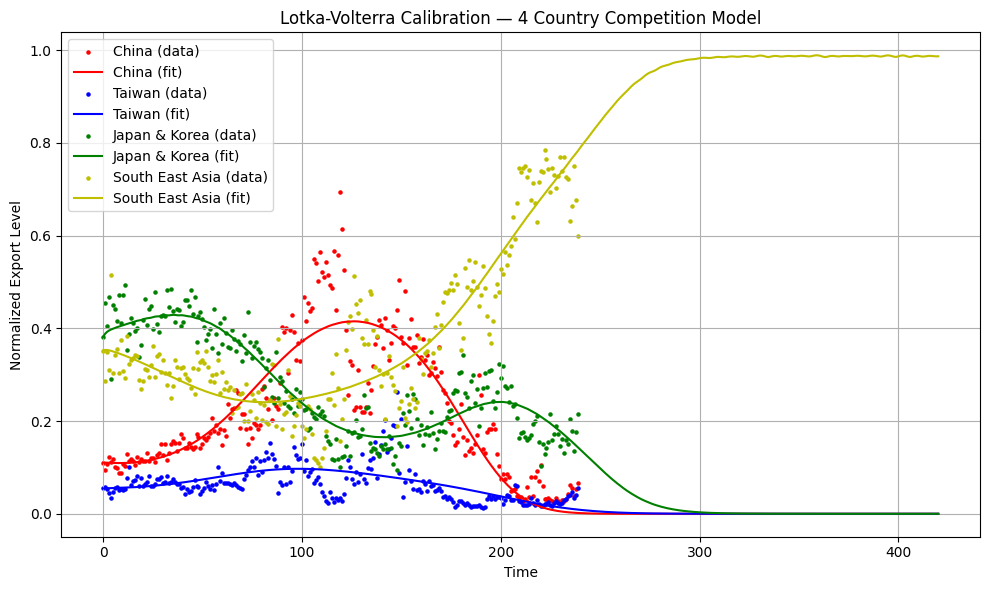

In [135]:
simulated_t_data = np.linspace(0, 420, 420)

# Solve the system using the fitted parameters
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_4_explicit(t, X, *fitted_params),
    t_span=(simulated_t_data[0], simulated_t_data[-1]),
    y0=X0,
    t_eval=simulated_t_data
)

# Plot results: data vs. model for all 4 countries
plt.figure(figsize=(10, 6))
colors = ['r', 'b', 'g', 'y']
labels = ['China', 'Taiwan', 'Japan & Korea', 'South East Asia']  # update names if needed

for i in range(4):
    plt.scatter(t_data, data[i], color=colors[i], s=5, label=f'{labels[i]} (data)')
    plt.plot(simulated_t_data, sol.y[i], f'{colors[i]}-', label=f'{labels[i]} (fit)')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration — 4 Country Competition Model')
plt.grid(True)
plt.tight_layout()
plt.show()
